In [2]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)

In [3]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [4]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [5]:
elements = ['Cu', 'Pt', 'Ag', 'Pd', 'Au', 'Ni', 'Al', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis

In [6]:
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        inst = dataset_utilizer(**dictlis[i])
        dfall.append(inst.dfall)
        df.append(inst.df)
        dfpred.append(inst.dfpred)
    except:
        print('a')

In [13]:
covset = []
for i in range(len(dfpred)):
    covset.append(sorted(list(set(dfpred['coverage']))))
covset

[[1.0], [1.0]]

### Just show residue ####

KeyError: 0

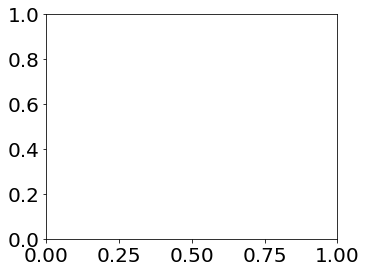

In [14]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
for i in range(len(dataset)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        data = dfpred[i][dfpred[i]['coverage'] == covset[0][0]]
        aveadsE_suratom = np.array(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['aveadsE/suratom'])
        E_residue = np.array(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

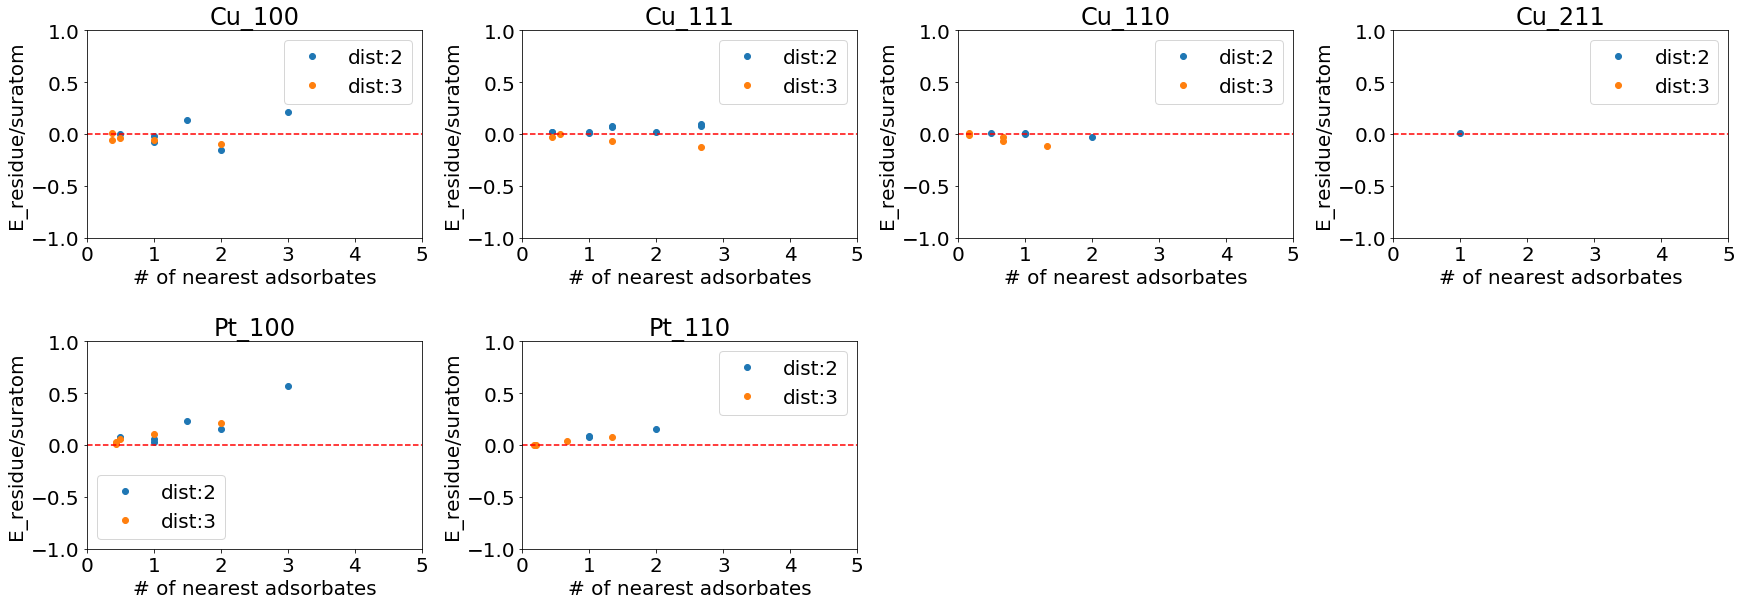

In [10]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 5
for i in range(len(dataset)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

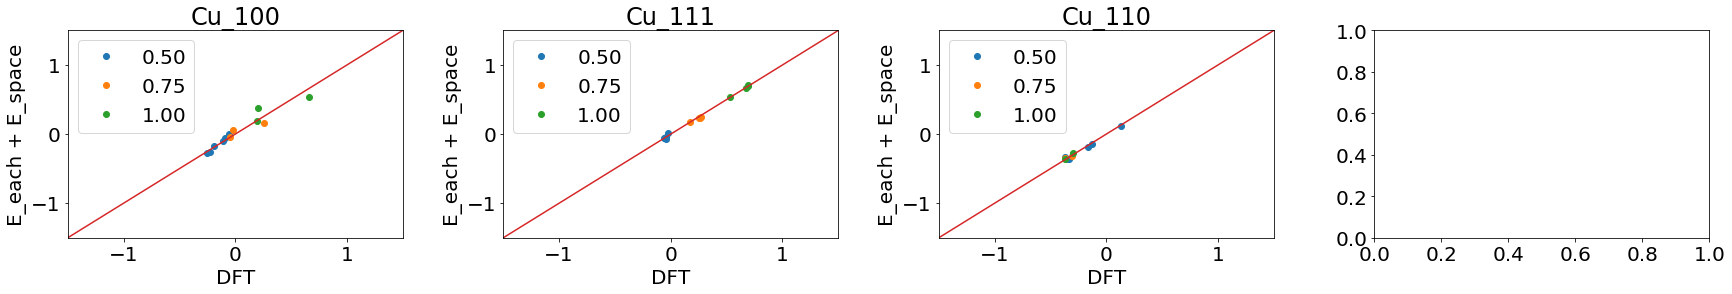

In [11]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

for i in range(len(dataset)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100
    weight2, weight3 = dataset[i].fit_weight_from_specific_element_and_face()

    for j in range(len(covset[i])):
        dfpred = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = dfpred['ads_dist2'] * weight2 + dfpred['ads_dist3'] * weight3
        E_ads_pred = (dfpred['E_int_space'] + dfpred['sumE_each_ads'])/dfpred['surfatomnum'] + E_residue_pred

        aveadsE_suratom = dfpred['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

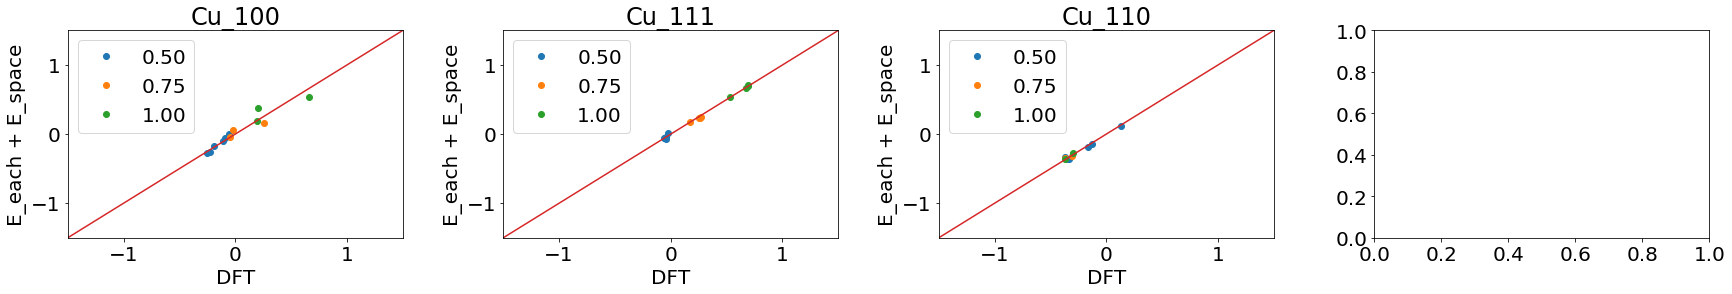

In [12]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

for i in range(len(dataset)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100
    weight2, weight3 = dataset[i].fit_weight_from_specific_element()

    for j in range(len(covset[i])):
        dfpred = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = dfpred['ads_dist2'] * weight2 + dfpred['ads_dist3'] * weight3
        E_ads_pred = (dfpred['E_int_space'] + dfpred['sumE_each_ads'])/dfpred['surfatomnum'] + E_residue_pred

        aveadsE_suratom = dfpred['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

In [19]:
for i in range(3):
    print(i)

0
1
2
